<a href="https://colab.research.google.com/github/PaulNjinu254/Neural-Network/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10 - Train Loss: 0.3029 | Val Loss: 0.3039
Epoch 2/10 - Train Loss: 0.2424 | Val Loss: 0.2498
Epoch 3/10 - Train Loss: 0.1993 | Val Loss: 0.2107
Epoch 4/10 - Train Loss: 0.1665 | Val Loss: 0.1813
Epoch 5/10 - Train Loss: 0.1411 | Val Loss: 0.1594
Epoch 6/10 - Train Loss: 0.1212 | Val Loss: 0.1427
Epoch 7/10 - Train Loss: 0.1055 | Val Loss: 0.1301
Epoch 8/10 - Train Loss: 0.0930 | Val Loss: 0.1205
Epoch 9/10 - Train Loss: 0.0828 | Val Loss: 0.1130
Epoch 10/10 - Train Loss: 0.0742 | Val Loss: 0.1071

Validation Accuracy: 96.84%


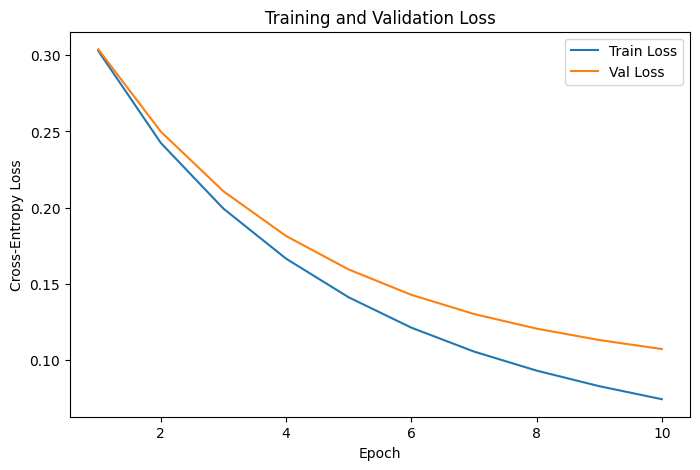

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess MNIST data

# Load MNIST dataset from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values (0-255) to (0,1) and flatten each 28x28 image to a 784-dim vector.
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test  = X_test.reshape(-1, 784).astype(np.float32) / 255.0

# One-hot encode the labels using sklearn's OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot  = encoder.transform(y_test.reshape(-1, 1))

# For demonstration, split the original training set further into training and validation.
X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42
)

# Define the GetMiniBatch iterator
class GetMiniBatch:
    """
    Iterator to retrieve mini-batches.
    """
    def __init__(self, X, y, batch_size=20, seed=42):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.seed = seed
        self.N = X.shape[0]
        self._shuffle_data()

    def _shuffle_data(self):
        np.random.seed(self.seed)
        self.indices = np.random.permutation(self.N)

    def __iter__(self):
        self._shuffle_data()
        self.batch_index = 0
        return self

    def __next__(self):
        if self.batch_index >= self.N:
            raise StopIteration()
        start = self.batch_index
        end = start + self.batch_size
        self.batch_index = end
        batch_indices = self.indices[start:end]
        return self.X[batch_indices], self.y[batch_indices]

# Define the ScratchSimpleNeuralNetrowkClassifier
class ScratchSimpleNeuralNetrowkClassifier:
    def __init__(self, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200,
                 n_output=10, sigma=0.02, lr=0.01, epoch=10, verbose=True):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []
        self._initialize_weights()

    def _initialize_weights(self):
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)

    def tanh_function(self, X):
        return np.tanh(X)

    def softmax(self, X):
        # Subtract max for numerical stability.
        X = X - np.max(X, axis=1, keepdims=True)
        exp_X = np.exp(X)
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)

    def cross_entropy_error(self, y, Z):
        # Add 1e-7 to avoid log(0) errors.
        return -np.sum(y * np.log(Z + 1e-7)) / len(y)

    def forward(self, X):
        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
        return self.Z3

    def backward(self, X, y):
        dA3 = (self.Z3 - y) / self.batch_size
        dW3 = self.Z2.T @ dA3
        dB3 = np.sum(dA3, axis=0, keepdims=True)
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2) ** 2)
        dW2 = self.Z1.T @ dA2
        dB2 = np.sum(dA2, axis=0, keepdims=True)
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1) ** 2)
        dW1 = X.T @ dA1
        dB1 = np.sum(dA1, axis=0, keepdims=True)

        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1

    def fit(self, X, y, X_val=None, y_val=None):
        for ep in range(self.epoch):
            mini_batches = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in mini_batches:
                self.forward(mini_X_train)
                self.backward(mini_X_train, mini_y_train)

            # Compute loss on full training set after each epoch.
            y_pred_train = self.forward(X)
            loss_train = self.cross_entropy_error(y, y_pred_train)
            self.loss_train.append(loss_train)

            if X_val is not None and y_val is not None:
                y_pred_val = self.forward(X_val)
                loss_val = self.cross_entropy_error(y_val, y_pred_val)
                self.loss_val.append(loss_val)
                if self.verbose:
                    print(f"Epoch {ep+1}/{self.epoch} - Train Loss: {loss_train:.4f} | Val Loss: {loss_val:.4f}")
            else:
                if self.verbose:
                    print(f"Epoch {ep+1}/{self.epoch} - Train Loss: {loss_train:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

# Train the network on MNIST data
nn = ScratchSimpleNeuralNetrowkClassifier(
    batch_size=64, n_features=784, n_nodes1=400, n_nodes2=200,
    n_output=10, sigma=0.02, lr=0.1, epoch=10, verbose=True
)
nn.fit(X_train, y_train_onehot, X_val, y_val_onehot)

# Evaluate on the validation set
from sklearn.metrics import accuracy_score
y_pred = nn.predict(X_val)
y_true = np.argmax(y_val_onehot, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

# plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, nn.epoch + 1), nn.loss_train, label="Train Loss")
if nn.loss_val:
    plt.plot(range(1, nn.epoch + 1), nn.loss_val, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
